In [2]:
'''
    Author: Robert Dwyer
    Date: 10/25/2017
    A multivariate LSTM neural Network designed to predict the current days S&P500 value based on the previous days closing
    price and volume traded
'''
import pandas as pd
import numpy as np
from numpy import concatenate
from numpy import sqrt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from subprocess import check_output
from numpy import newaxis
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import time

In [103]:
nyse = pd.read_csv('C:/Users/bobbyd/Desktop/data_science/git_repo/Trump-and-the-Stock-Market/nyse1.csv', skipfooter=2, engine = 'python')
nyse.head()

,Date,Open,Low,High,Close,Volume
0,"Aug 22, 2017",2433.75,2433.67,2454.77,2452.51,"1,588,714,000"
1,"Aug 18, 2017",2427.64,2420.69,2440.27,2425.55,"1,962,081,000"
2,"Aug 17, 2017",2462.95,2430.01,2465.02,2430.01,"1,929,351,000"
3,"Aug 15, 2017",2468.66,2461.61,2468.90,2464.61,"1,689,634,000"
4,"Aug 14, 2017",2454.96,2454.96,2468.22,2465.84,"1,586,224,000"


In [104]:
#preprocess Stock data
nyse.index = pd.DatetimeIndex(nyse['Date'])
nyse.sort_index(ascending=True, inplace=True)
nyse.drop('Date', axis=1, inplace=True)
nyse = nyse[['Close','Volume']]
nyse = nyse.resample('D').fillna('ffill')
nyse['Volume'] = nyse['Volume'].apply(lambda x: x.replace(',', ''))

In [107]:
#A function that will covert a time series database into a supervised learning database

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


nyse = nyse.astype('float32')



# scale data, reframe for supervised learning and drop target variable
scaler = MinMaxScaler(feature_range=(0,1))
scaled  = scaler.fit_transform(nyse)
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()
reframed.drop(reframed.columns[3], axis=1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.053499,0.090086,0.043353,0.075985
2,0.043353,0.075985,0.051401,0.068544
3,0.051401,0.068544,0.051401,0.068544
4,0.051401,0.068544,0.051401,0.068544
5,0.051401,0.068544,0.051401,0.068544


In [108]:
#split data into training and test
values= reframed.values
n_train_hours =365*4
train = values[:n_train_hours, :]
test = values[n_train_hours:,:]

#split data into inputs and outputs
train_X, train_y = train[:,:-1], train[:,-1] 
test_X, test_y = test[:,:-1], test[:,-1]

#required input shape for a LSTM is 3D
train_X = train_X.reshape(train_X.shape[0],1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0],1, test_X.shape[1])
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 1, 3) (1460,) (366, 1, 3) (366,)


Train on 1460 samples, validate on 366 samples
Epoch 1/50
0s - loss: 0.0729 - val_loss: 0.2844
Epoch 2/50
0s - loss: 0.0429 - val_loss: 0.2815
Epoch 3/50
0s - loss: 0.0365 - val_loss: 0.2948
Epoch 4/50
0s - loss: 0.0358 - val_loss: 0.2870
Epoch 5/50
0s - loss: 0.0345 - val_loss: 0.2857
Epoch 6/50
0s - loss: 0.0339 - val_loss: 0.2814
Epoch 7/50
0s - loss: 0.0335 - val_loss: 0.2774
Epoch 8/50
0s - loss: 0.0330 - val_loss: 0.2715
Epoch 9/50
0s - loss: 0.0325 - val_loss: 0.2654
Epoch 10/50
0s - loss: 0.0323 - val_loss: 0.2601
Epoch 11/50
0s - loss: 0.0318 - val_loss: 0.2531
Epoch 12/50
0s - loss: 0.0314 - val_loss: 0.2467
Epoch 13/50
0s - loss: 0.0310 - val_loss: 0.2398
Epoch 14/50
0s - loss: 0.0306 - val_loss: 0.2324
Epoch 15/50
0s - loss: 0.0302 - val_loss: 0.2249
Epoch 16/50
0s - loss: 0.0296 - val_loss: 0.2165
Epoch 17/50
0s - loss: 0.0293 - val_loss: 0.2090
Epoch 18/50
0s - loss: 0.0286 - val_loss: 0.1985
Epoch 19/50
0s - loss: 0.0281 - val_loss: 0.1886
Epoch 20/50
0s - loss: 0.0276 -

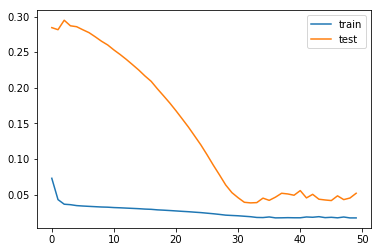

In [109]:
'''
    LSTM will defined with 1 hidden layer composed of 50 neurons and 1 output layer composed of 1 neuron

'''
# Design network
model =Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

#fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
#predict values and calculate Root Mean Squared Error score
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
rmse

0.091639746960620619